# Full Computation [9.7.1.1] - Backpropagation Through Time

This notebook demonstrates the full computation process for Backpropagation Through Time (BPTT) in Recurrent Neural Networks (RNNs). We'll visualize the storage of intermediate states and gradient flow through time steps.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
import seaborn as sns

## 1. Introduction to Full Computation in BPTT

Full computation in BPTT involves computing the entire gradient sum in the equation:

$$\frac{\partial h_t}{\partial w_h} = \frac{\partial f(x_t, h_{t-1}, w_h)}{\partial w_h} + \sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t}\frac{\partial f(x_j, h_{j-1}, w_h)}{\partial h_{j-1}}\right)\frac{\partial f(x_i, h_{i-1}, w_h)}{\partial w_h}$$

This approach:
- Computes gradients through *all* time steps without truncation
- Stores all intermediate states for backpropagation
- Captures long-term dependencies but can lead to:
  1. High memory usage
  2. Vanishing/exploding gradients
  3. Sensitivity to initial conditions (like the butterfly effect)

## 2. RNN with Full BPTT Implementation

In [2]:
# Define activation functions
def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return 1 - np.tanh(x)**2

# Model setup
class RNN:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights
        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(output_size, hidden_size) * 0.01
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
        
        # For storing intermediate states
        self.h_states = []
        self.h_raw = []
        self.y_preds = []
        
    def forward(self, x_sequence):
        # Initialize hidden state
        h = np.zeros((self.Whh.shape[0], 1))
        self.h_states = [h.copy()]
        self.h_raw = []
        self.y_preds = []
        
        # Forward pass through time
        for x in x_sequence:
            # Input to hidden
            h_raw = self.Wxh @ x + self.Whh @ h + self.bh
            h = tanh(h_raw)
            
            # Hidden to output
            y = self.Why @ h + self.by
            
            # Store all states
            self.h_raw.append(h_raw)
            self.h_states.append(h.copy())
            self.y_preds.append(y)
        
        return self.y_preds
    
    def backward(self, x_sequence, y_targets, learning_rate=0.01):
        # Initialize gradients
        dWxh = np.zeros_like(self.Wxh)
        dWhh = np.zeros_like(self.Whh)
        dWhy = np.zeros_like(self.Why)
        dbh = np.zeros_like(self.bh)
        dby = np.zeros_like(self.by)
        
        # Gradients of hidden state at t+1
        dh_next = np.zeros_like(self.h_states[0])
        
        # Log gradients for visualization
        gradient_magnitudes = []
        
        # Backpropagation through time
        T = len(x_sequence)
        for t in reversed(range(T)):
            # Gradient from output
            dy = self.y_preds[t] - y_targets[t]
            dWhy += dy @ self.h_states[t+1].T
            dby += dy
            
            # Gradient into hidden state: from output and from next time step
            dh = self.Why.T @ dy + dh_next
            
            # Gradient through tanh
            dh_raw = dtanh(self.h_raw[t]) * dh
            dbh += dh_raw
            
            # Gradient to weights
            dWxh += dh_raw @ x_sequence[t].T
            dWhh += dh_raw @ self.h_states[t].T
            
            # Gradient to previous hidden state
            dh_next = self.Whh.T @ dh_raw
            
            # Store gradient magnitude for visualization
            gradient_magnitudes.append(np.mean(np.abs(dh)))
            
        # Apply gradients
        self.Wxh -= learning_rate * dWxh
        self.Whh -= learning_rate * dWhh
        self.Why -= learning_rate * dWhy
        self.bh -= learning_rate * dbh
        self.by -= learning_rate * dby
        
        return gradient_magnitudes

## 3. Visualization of Full BPTT

In [3]:
def visualize_rnn_unfolding(sequence_length):
    """Visualize RNN unfolding through time with full computation"""
    plt.figure(figsize=(12, 6))
    
    # Parameters
    box_width = 1
    box_height = 1
    h_spacing = 2
    v_spacing = 1.5
    
    # Colors
    input_color = '#FFC107'  # amber
    hidden_color = '#2196F3'  # blue
    output_color = '#4CAF50'  # green
    arrow_color = '#9E9E9E'  # gray
    weight_color = '#E91E63'  # pink
    
    # Draw nodes and connections
    for t in range(sequence_length + 1):
        # Position for this time step
        x_pos = t * h_spacing
        
        if t < sequence_length:
            # Input node
            plt.gca().add_patch(Rectangle((x_pos, 0), box_width, box_height, 
                                         facecolor=input_color, alpha=0.7, edgecolor='black'))
            plt.text(x_pos + box_width/2, box_height/2, f'$x_{t}$', 
                     horizontalalignment='center', verticalalignment='center')
            
            # Output node
            plt.gca().add_patch(Rectangle((x_pos, 2*v_spacing), box_width, box_height, 
                                         facecolor=output_color, alpha=0.7, edgecolor='black'))
            plt.text(x_pos + box_width/2, 2*v_spacing + box_height/2, f'$y_{t}$', 
                     horizontalalignment='center', verticalalignment='center')
        
        # Hidden node
        plt.gca().add_patch(Rectangle((x_pos, v_spacing), box_width, box_height, 
                                     facecolor=hidden_color, alpha=0.7, edgecolor='black'))
        plt.text(x_pos + box_width/2, v_spacing + box_height/2, f'$h_{t}$', 
                 horizontalalignment='center', verticalalignment='center')
        
        if t < sequence_length:
            # Input to hidden connection
            arrow = FancyArrowPatch((x_pos + box_width/2, box_height), 
                                  (x_pos + box_width/2, v_spacing),
                                  arrowstyle='->', color=arrow_color, linewidth=1.5)
            plt.gca().add_patch(arrow)
            plt.text(x_pos + box_width/2 - 0.2, box_height + (v_spacing - box_height)/2, '$W_{xh}$',
                    color=weight_color)
            
            # Hidden to output connection
            arrow = FancyArrowPatch((x_pos + box_width/2, v_spacing + box_height), 
                                  (x_pos + box_width/2, 2*v_spacing),
                                  arrowstyle='->', color=arrow_color, linewidth=1.5)
            plt.gca().add_patch(arrow)
            plt.text(x_pos + box_width/2 - 0.2, v_spacing + box_height + (v_spacing - box_height)/2, '$W_{hy}$',
                    color=weight_color)
        
        # Recurrent connection (hidden to next hidden)
        if t < sequence_length:
            arrow = FancyArrowPatch((x_pos + box_width, v_spacing + box_height/2), 
                                  (x_pos + h_spacing, v_spacing + box_height/2),
                                  arrowstyle='->', color=arrow_color, linewidth=1.5, linestyle='--')
            plt.gca().add_patch(arrow)
            plt.text(x_pos + box_width + (h_spacing - box_width)/2, 
                    v_spacing + box_height/2 - 0.2, '$W_{hh}$', color=weight_color)
    
    # Draw backward pass
    for t in range(sequence_length-1, -1, -1):
        x_pos = t * h_spacing
        
        # Output to hidden backward
        arrow = FancyArrowPatch((x_pos + box_width/2, 2*v_spacing), 
                              (x_pos + box_width/2, v_spacing + box_height),
                              arrowstyle='<-', color='red', linewidth=1.0, linestyle=':')
        plt.gca().add_patch(arrow)
        
        # Hidden to previous hidden backward
        if t > 0:
            arrow = FancyArrowPatch((x_pos, v_spacing + box_height/2), 
                                  (x_pos - h_spacing + box_width, v_spacing + box_height/2),
                                  arrowstyle='<-', color='red', linewidth=1.0, linestyle=':')
            plt.gca().add_patch(arrow)
    
    # Label the backward arrows at the end
    plt.text(0.5 * h_spacing, 2*v_spacing - 0.2, r'$\frac{\partial L}{\partial y_t}$', color='red')
    plt.text(1.5 * h_spacing, v_spacing + 0.3, r'$\frac{\partial L}{\partial h_t}$', color='red')
    
    # Add title and adjust plot
    plt.title('Full Computation in BPTT: Unfolding RNN Through Time')
    plt.xlim(-0.5, sequence_length * h_spacing + 1)
    plt.ylim(-0.5, 3 * v_spacing)
    plt.axis('off')
    
    # Add a legend for forward and backward passes
    arrow_f = FancyArrowPatch((0, 0), (0.5, 0), arrowstyle='->', color=arrow_color, linewidth=1.5)
    arrow_b = FancyArrowPatch((0, 0), (0.5, 0), arrowstyle='<-', color='red', linewidth=1.0, linestyle=':')
    plt.legend([arrow_f, arrow_b], ['Forward Pass', 'Backward Pass'], 
              loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    
    plt.tight_layout()
    plt.show()

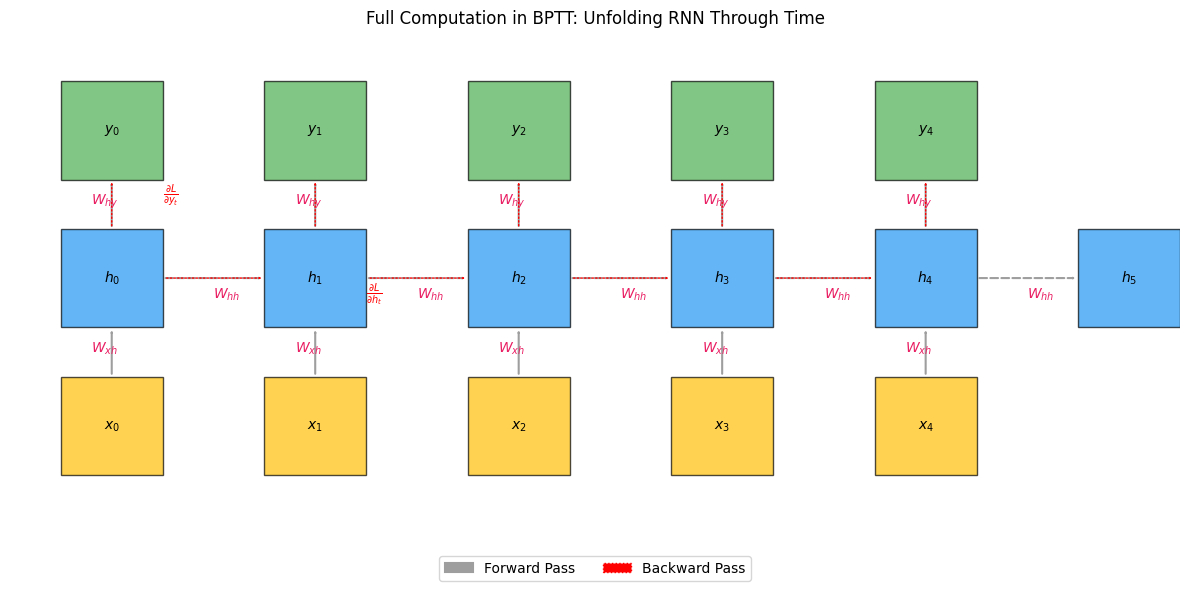

In [4]:
# Visualize full BPTT unfolding for a sequence of length 5
visualize_rnn_unfolding(5)

## 4. Demonstration of Gradient Behavior in Full BPTT

In [5]:
def run_gradient_experiment(sequence_lengths=[5, 10, 20, 50]):
    """Run experiments showing gradient behavior for different sequence lengths"""
    # Parameters
    input_size = 1
    hidden_size = 4
    output_size = 1
    
    # Results storage
    all_gradients = {}
    
    for seq_len in sequence_lengths:
        # Create a simple sine wave sequence
        x = np.linspace(0, 4*np.pi, seq_len)
        x_sequence = [np.array([[np.sin(val)]]) for val in x]
        y_targets = [np.array([[np.sin(val + 0.1)]]) for val in x]  # Shifted sine
        
        # Initialize RNN
        rnn = RNN(input_size, hidden_size, output_size)
        
        # Forward and backward passes
        rnn.forward(x_sequence)
        gradient_magnitudes = rnn.backward(x_sequence, y_targets)
        
        # Store results
        all_gradients[seq_len] = gradient_magnitudes
    
    # Visualization of gradient magnitudes
    plt.figure(figsize=(10, 6))
    
    for seq_len, grads in all_gradients.items():
        # Reverse to show gradients from start to end
        plt.plot(list(range(seq_len)), grads[::-1], label=f'Sequence Length: {seq_len}')
    
    plt.xlabel('Time Step')
    plt.ylabel('Average Gradient Magnitude')
    plt.title('Gradient Magnitudes in Full BPTT by Sequence Length')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale to show vanishing gradients
    plt.tight_layout()
    plt.show()
    
    return all_gradients

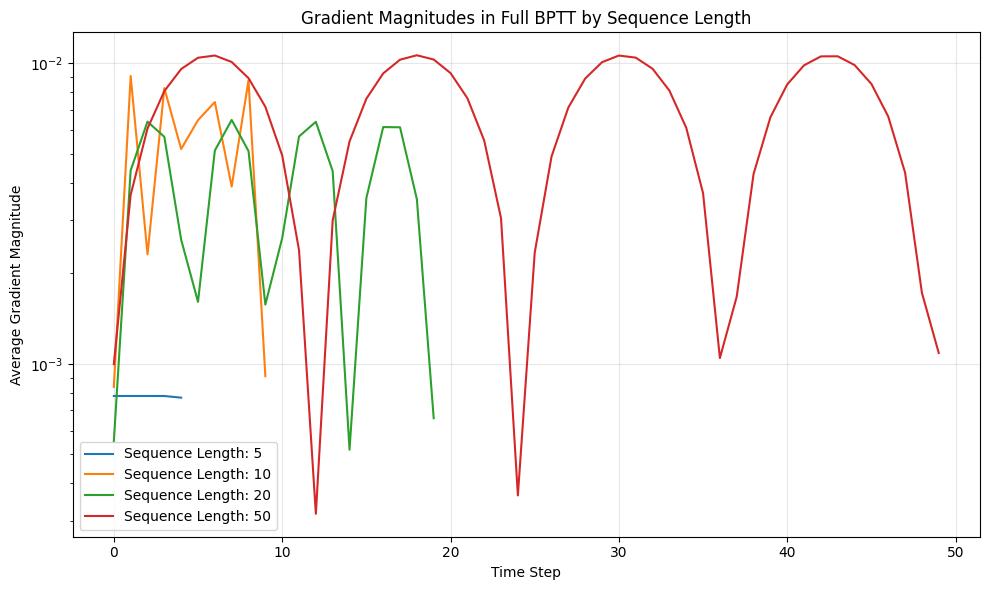

In [6]:
# Run gradient experiment
gradient_results = run_gradient_experiment()

## 5. The Challenges of Full Computation

From our visualization and experiments, we can observe several key properties of full BPTT computation:

1. **Memory Requirements**: Full BPTT requires storing all intermediate states for potentially long sequences.
   
2. **Vanishing Gradients**: As shown in our gradient plots, gradients from later time steps have a diminishing impact on earlier time steps. This is due to repeated multiplication with the hidden-to-hidden weight matrix.
   
3. **Computational Complexity**: The computational workload grows with sequence length, which can make training prohibitively expensive for very long sequences.

4. **Butterfly Effect**: Small changes in initial parameters can lead to dramatically different outcomes due to the recurrent nature of the computation.

5. **Mathematical Formulation**: The full gradient computation actually incorporates many sub-paths through the computational graph. From time step $t$ to time step $1$, we have to account for all possible paths.

These challenges often lead practitioners to employ alternatives like truncated BPTT or architectural solutions like LSTM/GRU cells.

## 6. Memory Storage Visualization

One key aspect of full computation is the need to store all intermediate states. Let's visualize this:

In [7]:
def visualize_memory_storage(sequence_length):
    """Visualize memory storage requirements for full BPTT"""
    plt.figure(figsize=(10, 6))
    
    # Generate data
    hidden_sizes = [4, 16, 64, 256]
    memory_usage = [[h_size * seq_len for seq_len in range(1, sequence_length+1)] for h_size in hidden_sizes]
    
    # Plot memory usage
    for i, h_size in enumerate(hidden_sizes):
        plt.plot(range(1, sequence_length+1), memory_usage[i], label=f'Hidden Size: {h_size}')
    
    plt.xlabel('Sequence Length')
    plt.ylabel('Relative Memory Units')
    plt.title('Memory Storage Requirements for Full BPTT')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

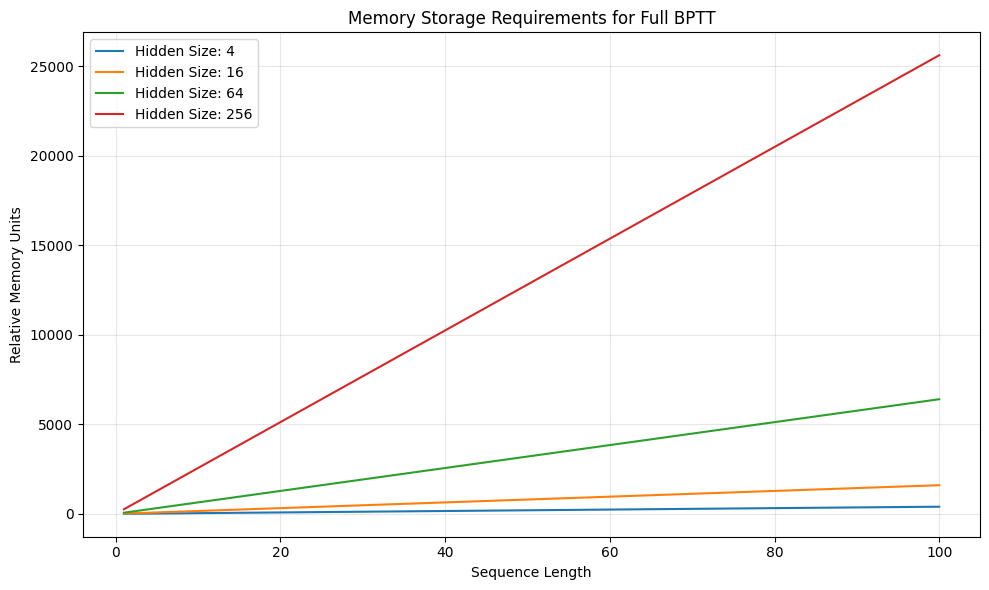

In [8]:
# Visualize memory storage for sequence lengths up to 100
visualize_memory_storage(100)

## 7. Conclusion

Full computation in BPTT provides the most accurate gradient estimates but comes with significant challenges:

- It requires storing all intermediate states, which grows linearly with sequence length
- It suffers from vanishing and exploding gradients for long sequences
- It is computationally expensive for long sequences

These challenges often lead to the use of truncated BPTT in practice, or specialized architectures like LSTMs and GRUs that are designed to mitigate some of these issues.

While full computation is theoretically complete, the practical considerations often outweigh the benefits of having exact gradients, especially for tasks involving very long sequences.

## References

1. Werbos, P. J. (1990). Backpropagation through time: what it does and how to do it. Proceedings of the IEEE, 78(10), 1550-1560.
2. Jaeger, H. (2002). Tutorial on training recurrent neural networks, covering BPTT, RTRL, EKF and the "echo state network" approach. GMD-Forschungszentrum Informationstechnik.
3. Bengio, Y., Simard, P., & Frasconi, P. (1994). Learning long-term dependencies with gradient descent is difficult. IEEE Transactions on Neural Networks, 5(2), 157-166.